# Building a Neural Network to Predict Loan Risk

## 1. Introduction

### 1.1 Data

I will be using a subset of the LendingClub DataSet obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

### 1.2 Goal of the analysis

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can I build a model that can predict wether or nor a borrower will pay back their loan? This way in the future when I get a new potential customer I can assess whether or not they are likely to pay back the loan.

For this project I will be using the libraries for data manipulation (Pandas, Numpy), regular expressions (Re), data visualization (Matplotlib, Seaborn), machine learning (Scikit-learn) and deep learning (Keras).

## 2. Exploratory Data Analysis

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [210]:
df = pd.read_csv('../DATA/lending_club_loan_two.csv')

In [211]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [212]:
#Let's create a function for easy lookup of feature descriptions throughout the notebook
data_info = pd.read_csv('../DATA/lending_club_info.csv',index_col='LoanStatNew')
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [213]:
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


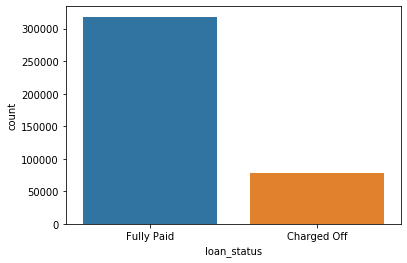

In [214]:
#It is a good idea to start with creating a countplot of the 'loan_status' column that contains the label
sns.countplot(data=df, x='loan_status')

There are much more fully paid loans than charged off ones - I have unbalanced dataset. Let's just keep it in mind.

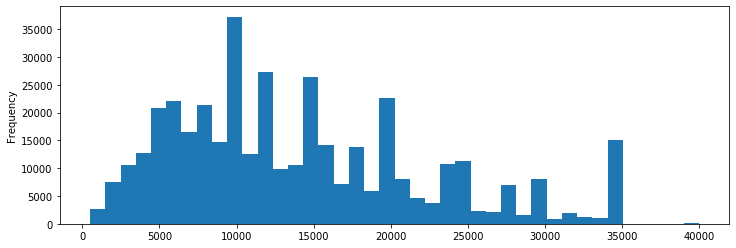

In [215]:
# Let's take a look at a histogram of the loan_amnt column.
plt.figure(figsize = (12,4))
df['loan_amnt'].plot.hist(bins=40)

In [216]:
#Let's explore correlation between the continuous feature variables
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


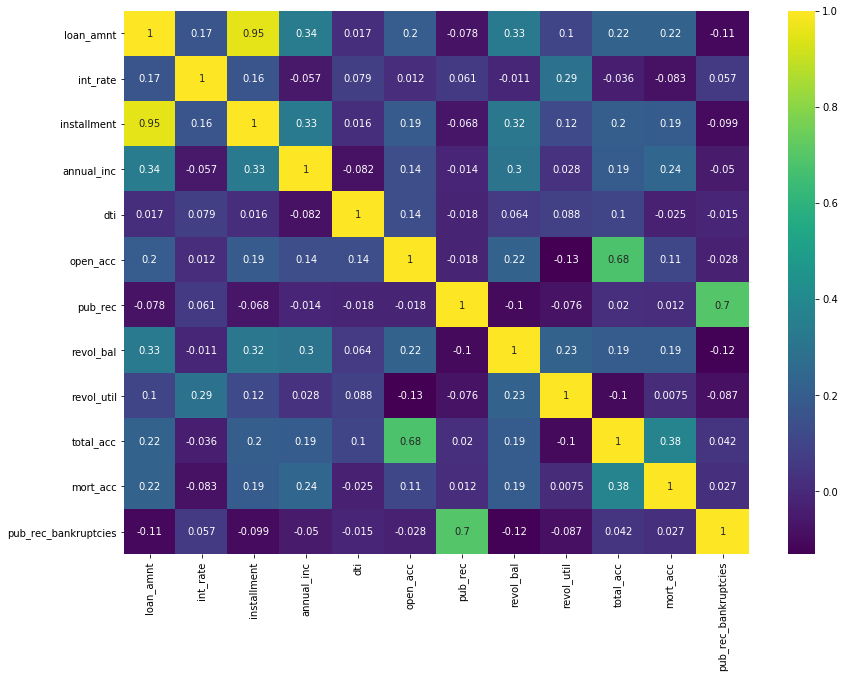

In [217]:
plt.figure(figsize=(14,10))
sns.heatmap(data=df.corr(),annot=True, cmap = "viridis")

I have noticed almost perfect correlation with the "installment" feature. Let's explore this feature further.

In [218]:
print(feat_info('installment'))
print(feat_info('loan_amnt'))

The monthly payment owed by the borrower if the loan originates.
None
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
None


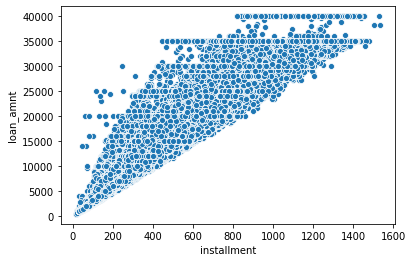

In [219]:
sns.scatterplot(data=df,x='installment',y='loan_amnt')

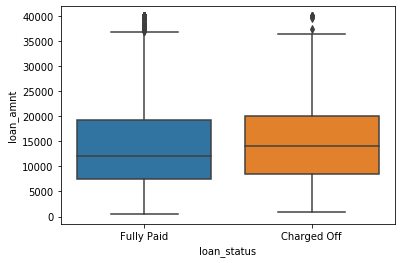

In [220]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

In [221]:
df.groupby(by='loan_status').describe()['loan_amnt']

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


Let's explore the Grade and SubGrade columns that LendingClub attributes to the loans.

In [222]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [223]:
sorted(df['sub_grade'].unique())

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

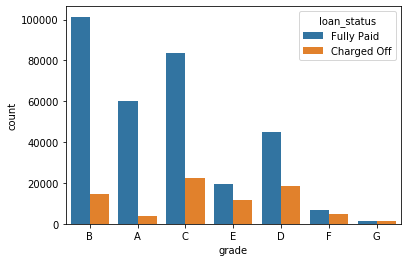

In [224]:
sns.countplot(x='grade',data=df,hue='loan_status')

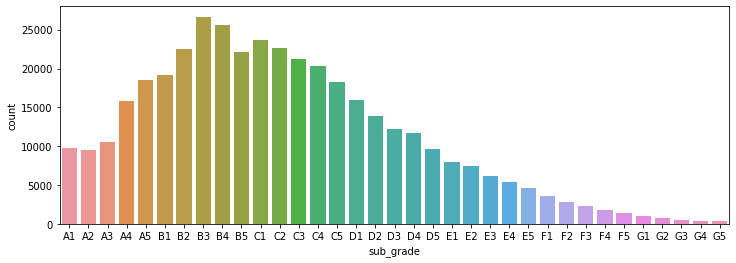

In [225]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order)

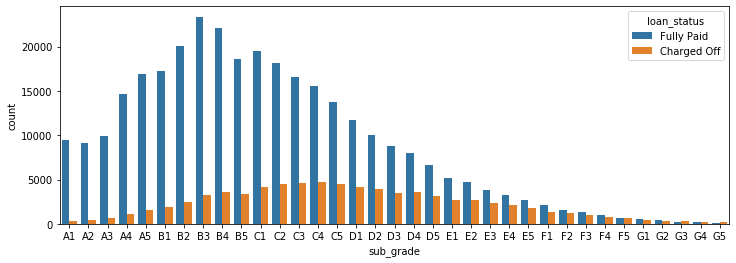

In [226]:
plt.figure(figsize=(12,4))
sns.countplot(data=df,x='sub_grade',order=subgrade_order, hue='loan_status')

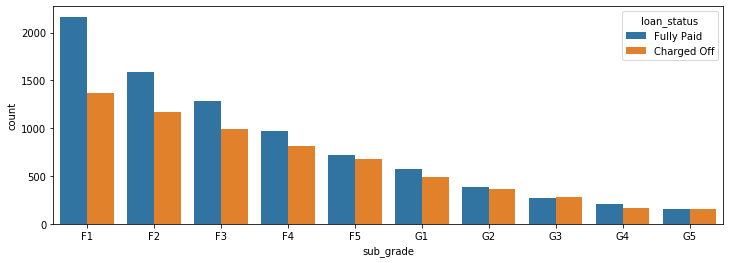

In [227]:
t = sorted(df[(df['grade']=='F')|(df['grade']=='G')]['sub_grade'].unique())
plt.figure(figsize=(12,4))
sns.countplot(data=df[(df['grade']=='F')|(df['grade']=='G')],x='sub_grade', hue='loan_status',order = t)

In [228]:
# Let's create a new column called 'loan_repaid' which will contain a 1 if the loan status was "Fully Paid" and a 0 if it was "Charged Off".
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})
df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


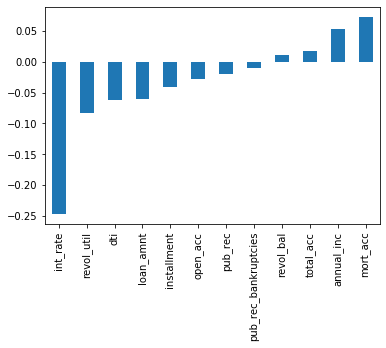

In [229]:
#Creating a bar plot showing the correlation of the numeric features to the new loan_repaid column.
df.corr()['loan_repaid'].drop('loan_repaid').sort_values().plot.bar()

## 3. Data Preprocessing

### 3.1 Missing Data

In [230]:
len(df)

396030

In [231]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [232]:
#Converting this Series to be in term of percentage of the dataframe
(df.isna().sum())/(len(df))*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [233]:
# Let's examine emp_title and emp_length to see whether it will be okay to drop them.
feat_info('emp_title')

The job title supplied by the Borrower when applying for the loan.*


In [234]:
feat_info('emp_length')

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [235]:
df['emp_title'].nunique()

173105

In [236]:
df['emp_title'].value_counts()

Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
                            ... 
Kohls Dept Stores              1
Avports Management Inc         1
American Builders Supply       1
ITT/Exelis Inc.                1
Marcus Theatres                1
Name: emp_title, Length: 173105, dtype: int64

In [237]:
#Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.
df.drop('emp_title',axis=1,inplace=True)

In [238]:
#Let's create a count plot of the emp_length feature column

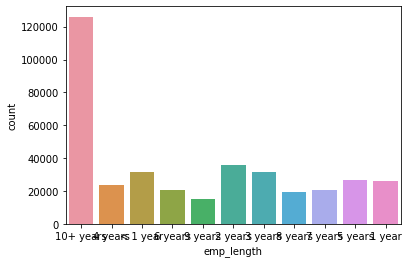

In [239]:
sns.countplot(data=df, x='emp_length')

In [240]:
emp_length_order = [ '< 1 year',
                      '1 year',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     '10+ years']

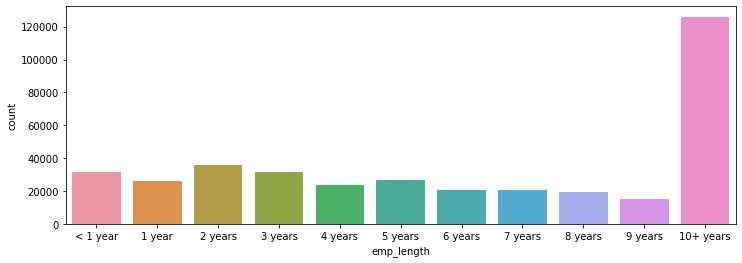

In [241]:
plt.figure(figsize = (12,4))
sns.countplot(data=df, x='emp_length', order = emp_length_order)

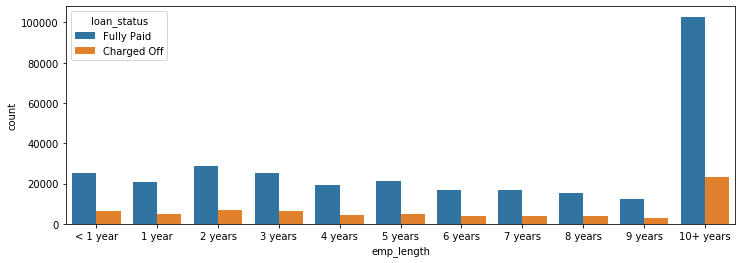

In [242]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,order=emp_length_order,hue='loan_status')

This still doesn't really inform us if there is a strong relationship between employment length and being charged off, what we want is the percentage of charge offs per category. Essentially informing us what percent of people per employment category didn't pay back their loan. 

In [243]:
b=df.loc[df['loan_status'] == 'Charged Off'].groupby('emp_length').count()['loan_status']
c=df.loc[df['loan_status'] == 'Fully Paid'].groupby('emp_length').count()['loan_status']

In [244]:
a=b/c
a

emp_length
1 year       0.248649
10+ years    0.225770
2 years      0.239560
3 years      0.242593
4 years      0.238213
5 years      0.237911
6 years      0.233341
7 years      0.241887
8 years      0.249625
9 years      0.250735
< 1 year     0.260830
Name: loan_status, dtype: float64

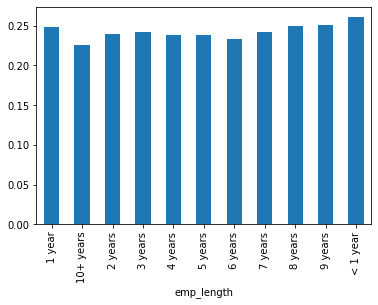

In [245]:
a.plot.bar()

Charge off rates are extremely similar across all employment lengths. Let's drop the emp_length column.

In [246]:
df.drop('emp_length',axis=1,inplace=True)

In [247]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [248]:
df['title'].head(10)

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

In [249]:
df['purpose'].head(10)

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object

The title column is simply a string subcategory/description of the purpose column. Let's drop the title column.

In [250]:
df.drop('title',axis=1,inplace=True)

In [251]:
feat_info('mort_acc')

Number of mortgage accounts.


In [252]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

In [253]:
df.corr()['mort_acc'].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

Looks like the total_acc feature correlates with the mort_acc , this makes sense! Let's try fillna() approach. We will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry. 

In [254]:
df.groupby('total_acc').mean()['mort_acc']

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

Let's fill in the missing mort_acc values based on their total_acc value. If the mort_acc is missing, then we will fill in that missing value with the mean value corresponding to its total_acc value from the Series we created above

In [255]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

In [256]:
total_acc_avg[3.0]

0.05202312138728324

In [257]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [258]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [259]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

 revol_util and the pub_rec_bankruptcies have missing data points, but they account for less than 0.5% of the total data. Let's remove the rows that are missing those values in those columns with dropna().

In [260]:
df.dropna(inplace=True)

In [261]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

### 3.2 Categorical Variables and Dummy Variables

In [262]:
df.select_dtypes(include=['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

Let's now go through all the string features to see what we should do with them.

In [263]:
#Convert the term feature into either a 36 or 60 integer numeric data type using .apply()
df['term'] = df['term'].apply(lambda x: int(x[:3]))

We already know grade is part of sub_grade, so let's just drop the grade feature

In [264]:
df.drop('grade', axis=1, inplace=True)

In [265]:
#Convert the subgrade into dummy variables
subgrade_dummies=pd.get_dummies(df['sub_grade'], drop_first=True)

In [266]:
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

In [267]:
#Converting these columns: ['verification_status', 'application_type','initial_list_status','purpose'] into dummy variables and concatenate them with the original dataframe
dummies=pd.get_dummies(df[['verification_status','application_type','initial_list_status','purpose']], drop_first=True)
df = df.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)
df = pd.concat([df,dummies],axis=1)

In [268]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [269]:
#Converting these to dummy variables, but replacing NONE and ANY with OTHER, so that we end up with just 4 categories, MORTGAGE, RENT, OWN,OTHER.
df['home_ownership'] = df['home_ownership'].replace('NONE','OTHER')
df['home_ownership'] = df['home_ownership'].replace('ANY','OTHER')

In [270]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          142
Name: home_ownership, dtype: int64

In [271]:
dummies=pd.get_dummies(df['home_ownership'], drop_first=True)
df = df.drop('home_ownership',axis=1)
df = pd.concat([df,dummies],axis=1)

In [272]:
#Let's feature engineer a zip code column from the address in the data set.
df['zip_code']=df['address'].apply(lambda x:x[-5:])
df['zip_code'].head()

0    22690
1    05113
2    05113
3    00813
4    11650
Name: zip_code, dtype: object

In [273]:
#Now let's make this zip_code column into dummy variables

In [274]:
len(df['zip_code'].value_counts())

10

In [275]:
dummies=pd.get_dummies(df['zip_code'], drop_first=True)
df = df.drop(['zip_code','address'],axis=1)
df = pd.concat([df,dummies],axis=1)

We wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, this would be data leakage. So let's drop this feature.

In [276]:
df.drop('issue_d',axis=1,inplace=True)

In [277]:
df['earliest_cr_line']

0         Jun-1990
1         Jul-2004
2         Aug-2007
3         Sep-2006
4         Mar-1999
            ...   
396025    Nov-2004
396026    Feb-2006
396027    Mar-1997
396028    Nov-1990
396029    Sep-1998
Name: earliest_cr_line, Length: 395219, dtype: object

In [278]:
df['earliest_cr_year']=df['earliest_cr_line'].apply(lambda x: x[-4:])
df['earliest_cr_year']=pd.to_numeric(df['earliest_cr_year'])

In [279]:
df['earliest_cr_year']

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396025    2004
396026    2006
396027    1997
396028    1990
396029    1998
Name: earliest_cr_year, Length: 395219, dtype: int64

In [280]:
df.drop('earliest_cr_line',axis=1,inplace=True)

## 4. Building a Neural Network

In [281]:
# First of all let's drop the load_status column we created earlier, since its a duplicate of the loan_repaid column. We'll use the loan_repaid column since its already in 0s and 1s.
df.drop('loan_status',axis=1,inplace=True)

In [282]:
from sklearn.model_selection import train_test_split

In [283]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 4.1 Normalizing the Data

In [285]:
from sklearn.preprocessing import MinMaxScaler

In [286]:
scaler = MinMaxScaler()

In [287]:
X_train = scaler.fit_transform(X_train)

In [288]:
X_test = scaler.transform(X_test)

### 4.2 Creating the Model

In [289]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [290]:
X_train.shape

(296414, 78)

In [291]:
model = Sequential()

model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [292]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=50,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/50
1158/1158 [==============================] - 5s 4ms/step - loss: 0.2995 - val_loss: 0.2623
Epoch 2/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2661 - val_loss: 0.2607
Epoch 3/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2636 - val_loss: 0.2594
Epoch 4/50
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2626 - val_loss: 0.2594
Epoch 5/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2615 - val_loss: 0.2601
Epoch 6/50
1158/1158 [==============================] - 4s 4ms/step - loss: 0.2611 - val_loss: 0.2588
Epoch 7/50
1158/1158 [==============================] - 4s 4ms/step - loss: 0.2606 - val_loss: 0.2592
Epoch 8/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2605 - val_loss: 0.2590
Epoch 9/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2600 - val_loss: 0.2590
Epoch 10/50
1158/1158 [==============================] - 4s 4ms/step - loss: 0.259

In [293]:
from tensorflow.keras.models import load_model

In [294]:
model.save('full_data_project_model.h5') 

### 4.3 Evaluating Model Performance

In [296]:
model_loss = pd.DataFrame(model.history.history)

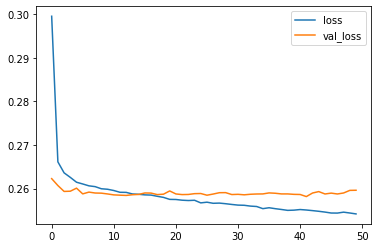

In [297]:
model_loss[['loss','val_loss']].plot()

In [298]:
from sklearn.metrics import classification_report,confusion_matrix

In [299]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [300]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62     19307
           1       0.88      0.99      0.94     79498

    accuracy                           0.89     98805
   macro avg       0.91      0.73      0.78     98805
weighted avg       0.89      0.89      0.87     98805



In [301]:
confusion_matrix(y_test,predictions)

array([[ 8893, 10414],
       [  559, 78939]])

## 5. Conclusion

We can see that our model is pretty good in identifying those who fully paid the loan, but very far from being good in identifying those who was charged off. Indeed, recall = 0,46 means that only 46% of those who were actually charged off were labeled correctly by our model. This is not a satisfactory result! We would prefer to have high f1 score for charged off and would be ok with lower f1 score for fully paid since from business point of view it is much more important not to give a loan to those who will not pay, than to give a loan to everybody who will pay.

NOTE! THIS PROJECT IS NOT FINISHED AND THE NEURAL NETWORK WILL BE MODIFIYED FURTHER! I have not tuned hyperparameters of the model yet. What I am going to do is to use Keras tuner to autotune hyperparameters.
Moreover, I will try different combinations of input variables and will start with excluding zip codes from the analysis. I included such questionable variables as zip codes and year only because it was important to me to practice in data preprocessing and feature engineering.

Finally, in the next updates I am going to build another models using Logistic Regression, Support Vector Machines and a couple of tree-based models and then choose the model with the best performance.

Currently I am pretty satisfied with exploratory analysis and data preprocessing parts. Let's see if I will be able to achieve higher f1 score in the next updates!